In [1]:
#SECONDE VERSION DU SCRIPT DE PREDICTION (AVEC LE CHARGEMENT DE LA TOTALITE DES DONNES)

import pandas as pd
import gc

# 1) Chargement de title.ratings 
ratings = pd.read_csv(
    "/mnt/c/Users/donov/Bureau/IMDB/data/raw/title.ratings.tsv",
    sep="\t", na_values="\\N",
    usecols=["tconst", "averageRating", "numVotes"],
    dtype={"tconst": "string"},    
    low_memory=False
)

# conversions en numeric
ratings["averageRating"] = pd.to_numeric(ratings["averageRating"], errors="coerce")
ratings["numVotes"] = pd.to_numeric(ratings["numVotes"], errors="coerce").astype("Int64")
ratings = ratings.dropna(subset=["averageRating"]).set_index("tconst")

# 2) Charegement de title.basics par chunks : 
usecols = ["tconst","primaryTitle","originalTitle","startYear","titleType","genres","runtimeMinutes"]
chunksize = 200_000  

parts = []
reader = pd.read_csv(
    "/mnt/c/Users/donov/Bureau/IMDB/data/raw/title.basics.tsv",
    sep="\t",
    na_values="\\N",
    usecols=usecols,
    dtype=str,              
    chunksize=chunksize,
    low_memory=False,       
    engine="c"
)

for i, chunk in enumerate(reader, 1):
    
    # conversions dans le chunk
    chunk["startYear"] = pd.to_numeric(chunk["startYear"], errors="coerce").astype("Int64")
    chunk["runtimeMinutes"] = pd.to_numeric(chunk["runtimeMinutes"], errors="coerce").astype("Int64")
    
    # on garde tout en string pour les colonnes texte et eviter les errors
    for col in ["tconst","primaryTitle","originalTitle","titleType","genres"]:
        if col in chunk.columns:
            chunk[col] = chunk[col].astype("string")

    # filtres pour réduire la taille
    chunk = chunk[chunk["startYear"].fillna(0) >= 2000]
    chunk = chunk[chunk["titleType"] == "movie"]

    if chunk.empty:
        continue

    # On effectue le join sur ratings
    merged = chunk.join(ratings, on="tconst", how="left")
    merged = merged.dropna(subset=["averageRating"])

    parts.append(merged)
    del chunk, merged
    gc.collect()
    print(f"Chunk {i} ok")

data = pd.concat(parts, ignore_index=True)
print("Taille finale :", data.shape)


Chunk 1 ok
Chunk 2 ok
Chunk 3 ok
Chunk 4 ok
Chunk 5 ok
Chunk 6 ok
Chunk 7 ok
Chunk 8 ok
Chunk 9 ok
Chunk 10 ok
Chunk 11 ok
Chunk 12 ok
Chunk 13 ok
Chunk 14 ok
Chunk 15 ok
Chunk 16 ok
Chunk 17 ok
Chunk 18 ok
Chunk 19 ok
Chunk 20 ok
Chunk 21 ok
Chunk 22 ok
Chunk 23 ok
Chunk 24 ok
Chunk 25 ok
Chunk 26 ok
Chunk 27 ok
Chunk 28 ok
Chunk 29 ok
Chunk 30 ok
Chunk 31 ok
Chunk 32 ok
Chunk 33 ok
Chunk 34 ok
Chunk 35 ok
Chunk 36 ok
Chunk 37 ok
Chunk 38 ok
Chunk 39 ok
Chunk 40 ok
Chunk 41 ok
Chunk 42 ok
Chunk 43 ok
Chunk 44 ok
Chunk 45 ok
Chunk 46 ok
Chunk 47 ok
Chunk 48 ok
Chunk 49 ok
Chunk 50 ok
Chunk 51 ok
Chunk 52 ok
Chunk 53 ok
Chunk 54 ok
Chunk 55 ok
Chunk 56 ok
Chunk 57 ok
Chunk 58 ok
Chunk 59 ok
Taille finale : (197747, 9)


In [2]:
# Packages complémentaires
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy import sparse as sp
from sklearn.model_selection import GridSearchCV

In [4]:
# 1) Encodage des genres (multi-label)
data['genres_split'] = data['genres'].fillna('').str.split(',')
data['genres_split'] = data['genres_split'].apply(lambda x: [] if x == [''] else x)
mlb = MultiLabelBinarizer(sparse_output=True)
genres_sparse = mlb.fit_transform(data['genres_split']).astype(np.float32)

# 2) Encodage one-hot de titleType
ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
titleType_sparse = ohe.fit_transform(data[['titleType']]).astype(np.float32)

# 3) Conversion en float32 des colonnes numériques
data['startYear'] = pd.to_numeric(data['startYear'], errors='coerce')
data['numVotes']  = pd.to_numeric(data['numVotes'], errors='coerce')
data['averageRating'] = pd.to_numeric(data['averageRating'], errors='coerce')

# Filtre des lignes sans NaN et avec suffisamment de votes (>=100)
mask = data[['startYear', 'numVotes', 'averageRating']].notna().all(axis=1)
data = data.loc[mask].copy()
data = data[data['numVotes'] >= 100]

# Matrice numérique
num_array = data[['startYear', 'numVotes']].to_numpy(dtype=np.float32)
num_mat = sp.csr_matrix(num_array)

# Preparation des X et y

# 4) Empilement sparse
X_sparse = sp.hstack([num_mat, genres_sparse, titleType_sparse], format='csr')
y = data['averageRating'].to_numpy(dtype=np.float32)

# Vérification des dimensions
print("X shape:", X_sparse.shape)
print("y shape:", y.shape)


X shape: (86682, 29)
y shape: (86682,)


[LinearRegression] RMSE=1.3560 | MSE=1.8386 | R² train=0.0172 | R² test=0.0175
[RandomForest]    RMSE=1.1722 | MSE=1.3740 | R² train=0.8743 | R² test=0.2658


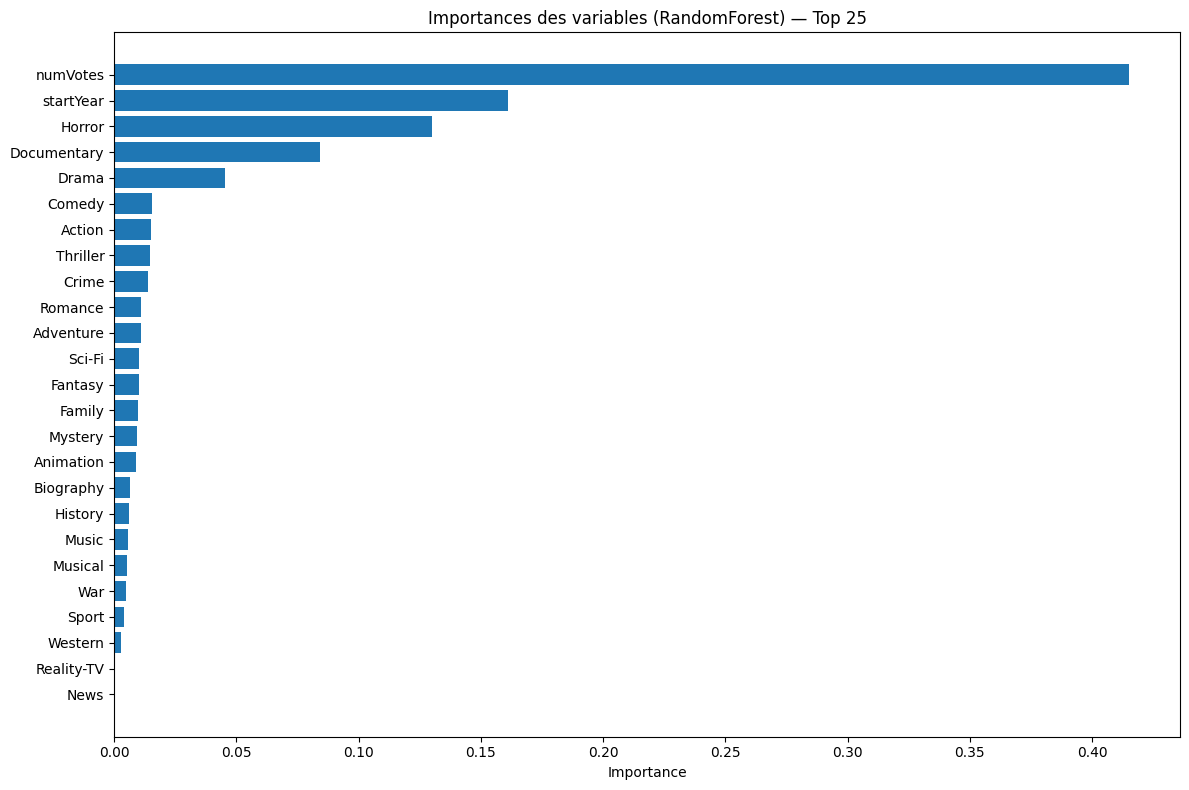

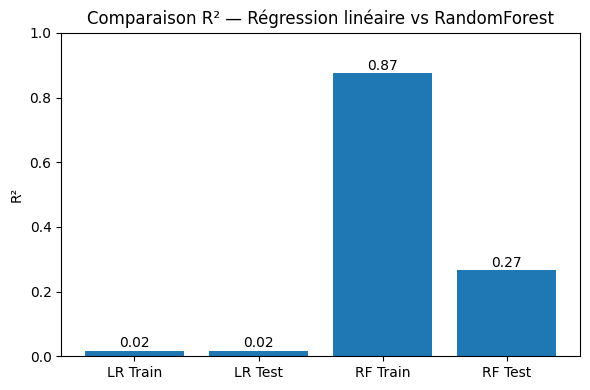


Top 15 features (RF):
    feature  importance
   numVotes    0.415215
  startYear    0.160972
     Horror    0.129832
Documentary    0.084122
      Drama    0.045187
     Comedy    0.015554
     Action    0.014897
   Thriller    0.014591
      Crime    0.013854
    Romance    0.010822
  Adventure    0.010767
     Sci-Fi    0.010324
    Fantasy    0.010064
     Family    0.009622
    Mystery    0.009203


In [5]:
# 0) Reconstitution des noms de features dans le même ordre que le hstack

feature_names = (
    ['startYear', 'numVotes']
    + list(mlb.classes_)                                 # mêmes classes que pour genres_sparse
    + list(ohe.get_feature_names_out(['titleType']))     # mêmes colonnes que pour titleType_sparse
)

# 1) Dense (peu de colonnes → OK en mémoire)
X = X_sparse.toarray().astype(np.float32)

# 2) Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# A) Régression linéaire

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr_train = lr.predict(X_train)
pred_lr_test  = lr.predict(X_test)

mse_lr  = mean_squared_error(y_test, pred_lr_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr_test))
r2_lr_train = r2_score(y_train, pred_lr_train)
r2_lr_test  = r2_score(y_test,  pred_lr_test)

print(f"[LinearRegression] RMSE={rmse_lr:.4f} | MSE={mse_lr:.4f} | "
      f"R² train={r2_lr_train:.4f} | R² test={r2_lr_test:.4f}")


# B) Random Forest

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

pred_rf_train = rf.predict(X_train)
pred_rf_test  = rf.predict(X_test)

mse_rf  = mean_squared_error(y_test, pred_rf_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf_test))
r2_rf_train = r2_score(y_train, pred_rf_train)
r2_rf_test  = r2_score(y_test,  pred_rf_test)

print(f"[RandomForest]    RMSE={rmse_rf:.4f} | MSE={mse_rf:.4f} | "
      f"R² train={r2_rf_train:.4f} | R² test={r2_rf_test:.4f}")


# C) Importances des features (RandomForest)

importances = rf.feature_importances_
feat_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feat_df["feature"][:25][::-1], feat_df["importance"][:25][::-1])  # Top 25, du bas vers le haut
plt.title("Importances des variables (RandomForest) — Top 25")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("/mnt/c/Users/donov/Bureau/IMDB/outputs/Importances des variables V2 (RandomForest).png")
plt.show()



# D) Comparaison R² (barres)

labels = ["LR Train", "LR Test", "RF Train", "RF Test"]
scores = [r2_lr_train, r2_lr_test, r2_rf_train, r2_rf_test]

plt.figure(figsize=(6,4))
plt.bar(labels, scores)
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")
plt.ylim(0, 1)
plt.ylabel("R²")
plt.title("Comparaison R² — Régression linéaire vs RandomForest")
plt.tight_layout()

plt.savefig("/mnt/c/Users/donov/Bureau/IMDB/outputs/Comparaison R² - Régression Linéaire vs RandomForest.png")
plt.show()


# Visualisation du Top 15 des features

print("\nTop 15 features (RF):")
print(feat_df.head(15).to_string(index=False))
